# Statistical Downscaling of CanRCM4 Model Using 2.5 km HRDPS Data
## Data Preprocessing

In [1]:
#import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import datetime

#for linear regression
import statsmodels.api as sm
from sklearn import linear_model

#for NN
from sklearn.neural_network import MLPRegressor

In [2]:
#load in data (both U and V processed in this file)
U_RCM_eigvecs = pd.read_csv('U_RCM_eigvecs.csv',header=None).to_numpy()
U_RCM_fracvar = pd.read_csv('U_RCM_fracVar.csv',header=None)[0].to_numpy()
U_RCM_PCs = pd.read_csv('U_RCM_PCs.csv',header=None).to_numpy()
V_RCM_eigvecs = pd.read_csv('V_RCM_eigvecs.csv',header=None).to_numpy()
V_RCM_fracvar = pd.read_csv('V_RCM_fracVar.csv',header=None)[0].to_numpy()
V_RCM_PCs = pd.read_csv('V_RCM_PCs.csv',header=None).to_numpy()

RCM_lat = pd.read_csv('RCM_lat.csv',header=None)[0].to_numpy()
RCM_lon = pd.read_csv('RCM_lon.csv',header=None)[0].to_numpy()

U_hrdps_eigvecs = pd.read_csv('U_hrdps_eigvecs.csv',header=None).to_numpy()
U_hrdps_fracvar = pd.read_csv('U_hrdps_fracVar.csv',header=None)[0].to_numpy()
U_hrdps_PCs = pd.read_csv('U_hrdps_PCs.csv',header=None).to_numpy()
V_hrdps_eigvecs = pd.read_csv('V_hrdps_eigvecs.csv',header=None).to_numpy()
V_hrdps_fracvar = pd.read_csv('V_hrdps_fracVar.csv',header=None)[0].to_numpy()
V_hrdps_PCs = pd.read_csv('V_hrdps_PCs.csv',header=None).to_numpy()

hrdps_lat = pd.read_csv('hrdps_lat.csv',header=None)[0].to_numpy()
hrdps_lon = pd.read_csv('hrdps_lon.csv',header=None)[0].to_numpy()

In [3]:
#generate dates
time2014 = pd.date_range(start=datetime.datetime(2014,1,1),end=datetime.datetime(2020,12,31))
time2015 = pd.date_range(start=datetime.datetime(2015,1,1),end=datetime.datetime(2020,12,31))

#drop leap days
time2014 = np.delete(time2014,[list(time2014).index(datetime.datetime(2016,2,29)),list(time2014).index(datetime.datetime(2020,2,29))])
time2015 = np.delete(time2015,[list(time2015).index(datetime.datetime(2016,2,29)),list(time2015).index(datetime.datetime(2020,2,29))])

## PCA 
First on CanRCM4 Model

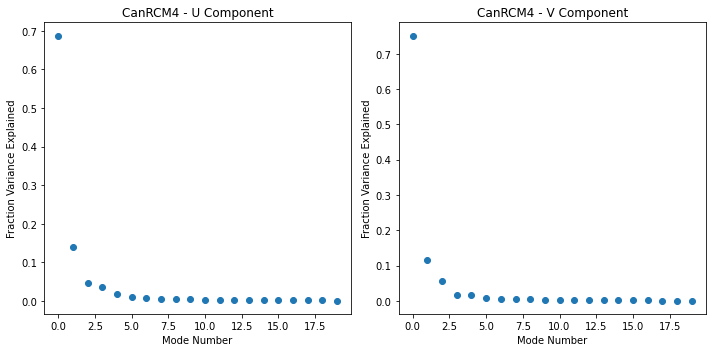

In [4]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(U_RCM_fracvar[0:20])),U_RCM_fracvar[0:20])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('CanRCM4 - U Component')

plt.subplot(1,2,2)
plt.scatter(range(len(V_RCM_fracvar[0:20])),V_RCM_fracvar[0:20])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('CanRCM4 - V Component')

plt.tight_layout()

plt.show()

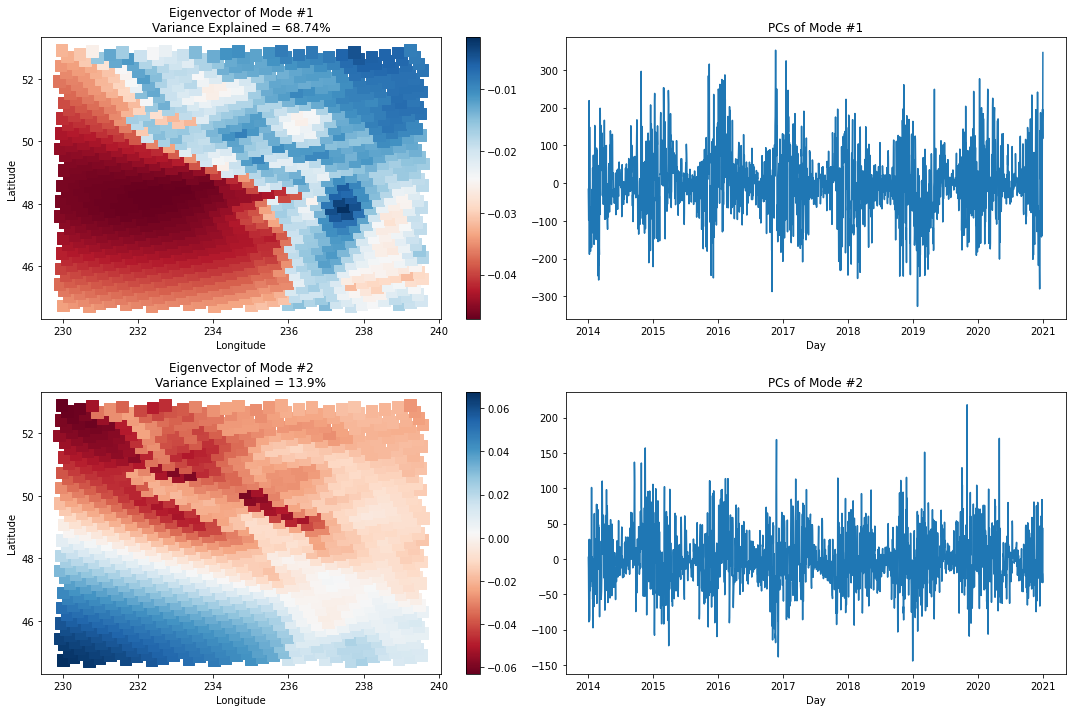

In [5]:
#keep first two modes for U
#visualise U component
n = 2

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(RCM_lon, RCM_lat,
            c = U_RCM_eigvecs[kk,:],
            cmap = 'RdBu',
            s = 133,
            marker = 's')
    plt.title('Eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(U_RCM_fracvar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(time2014,U_RCM_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()
    
#plt.savefig('PCA-RXM-U.png')

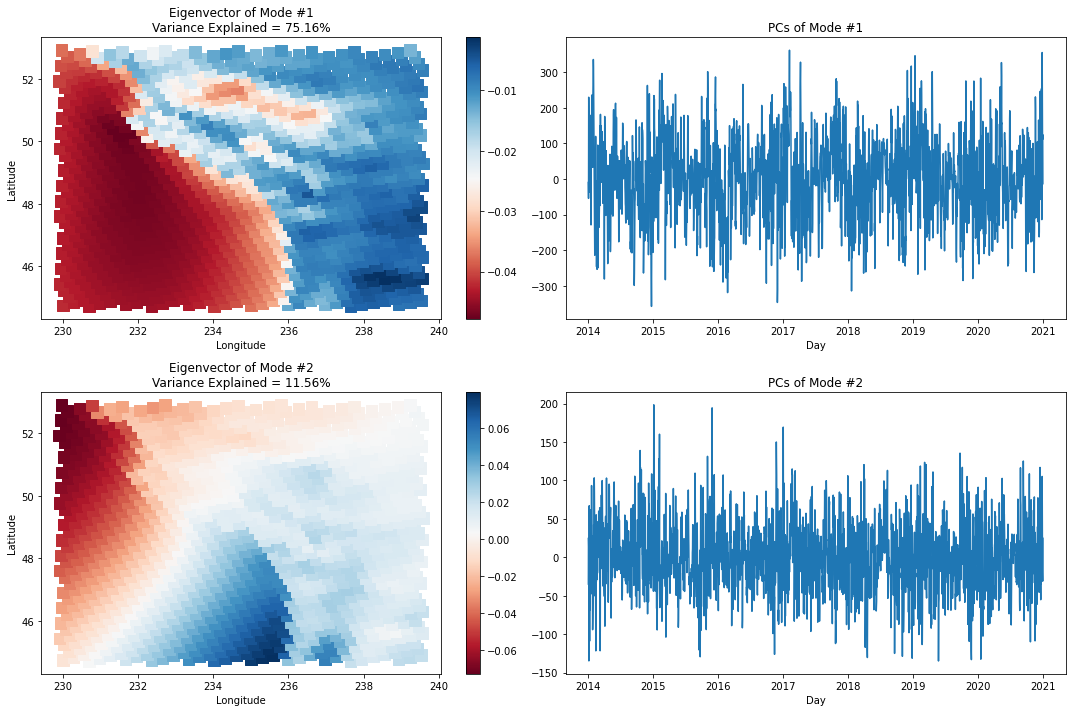

In [6]:
#keep first two modes for V
#visualise V component
n = 2

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(RCM_lon, RCM_lat,
            c = V_RCM_eigvecs[kk,:],
            cmap = 'RdBu',
            s = 133,
            marker = 's')
    plt.title('Eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(V_RCM_fracvar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(time2014,V_RCM_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()
    
#plt.savefig('PCA-RXM-U.png')

Now on the HRDPS Data

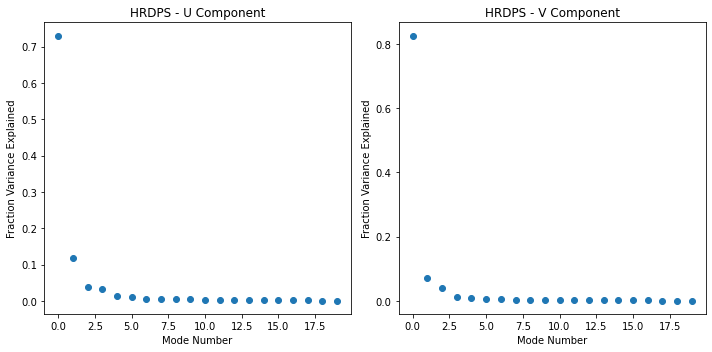

In [7]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(U_hrdps_fracvar[0:20])),U_hrdps_fracvar[0:20])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('HRDPS - U Component')

plt.subplot(1,2,2)
plt.scatter(range(len(V_hrdps_fracvar[0:20])),V_hrdps_fracvar[0:20])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('HRDPS - V Component')

plt.tight_layout()

plt.show()

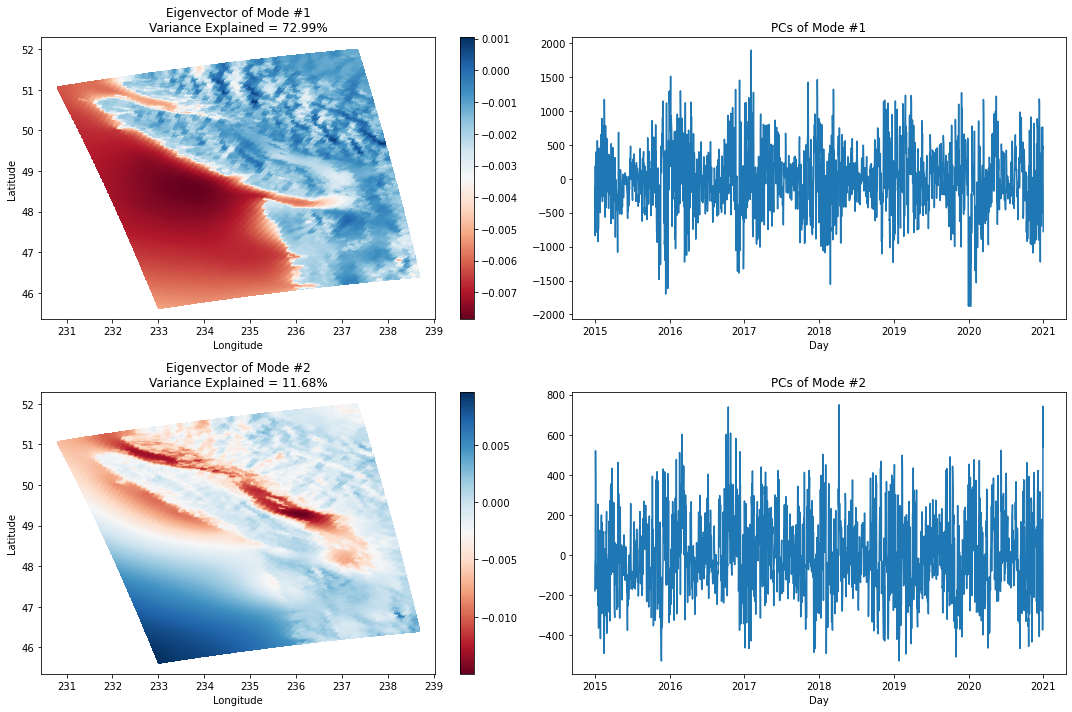

In [8]:
#keep first two modes for U component
#visualise U component
n = 2

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(hrdps_lon, hrdps_lat,
            c = U_hrdps_eigvecs[kk,:],
            cmap = 'RdBu',
            s = 10,
            marker = 's')
    plt.title('Eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(U_hrdps_fracvar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(time2015,U_hrdps_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()

#plt.savefig('PCA-HRDPS-U.png')

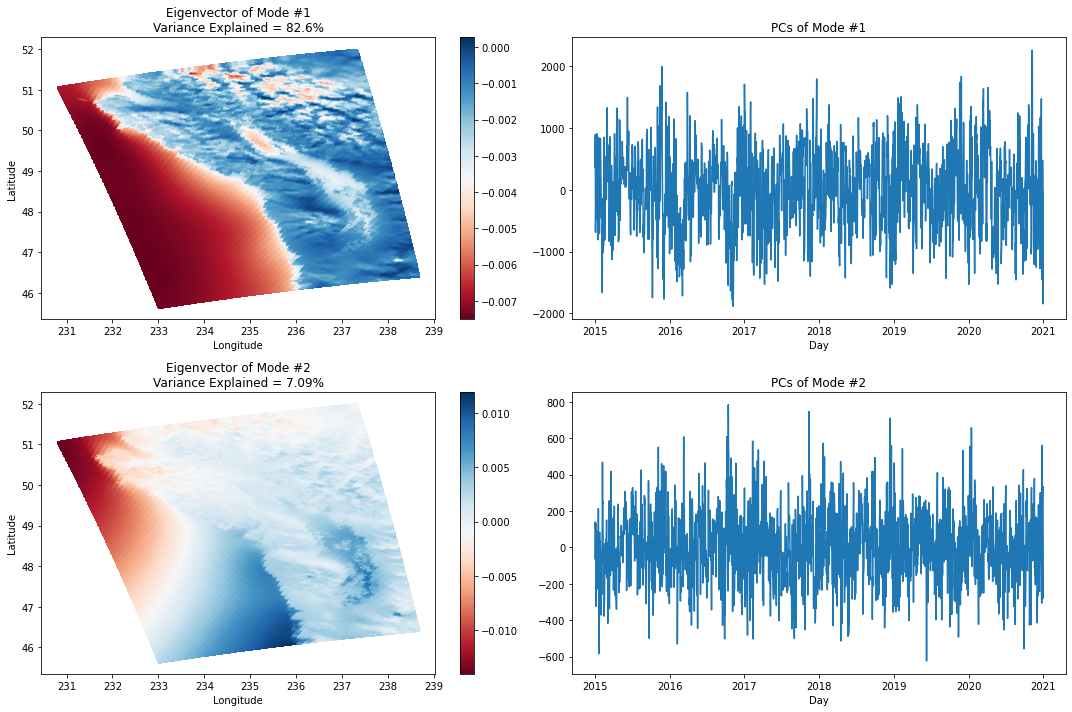

In [14]:
#keep first mode for V component
#visualise V component
n = 2

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(hrdps_lon, hrdps_lat,
            c = V_hrdps_eigvecs[kk,:],
            cmap = 'RdBu',
            s = 10,
            marker = 's')
    plt.title('Eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(V_hrdps_fracvar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(time2015,V_hrdps_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()

#plt.savefig('PCA-HRDPS-U.png'))

## Normalization
The spatial plots above are interesting to look at and help to show that the first to modes from all datesets are showing very similar spatial patterns - mode 1s and mode 2s will be compared between datasets

In [10]:
# #U RCM
# U_RCM_norm = [(U_RCM_PCs[ii,0]+U_RCM_PCs[ii,1]) for ii in range(len(U_RCM_PCs))]

# #V RCM
# V_RCM_norm = [(V_RCM_PCs[ii,0]+V_RCM_PCs[ii,1]) for ii in range(len(V_RCM_PCs))]

# #U hrdps
# U_hrdps_norm = [(U_hrdps_PCs[ii,0]+U_hrdps_PCs[ii,1]) for ii in range(len(U_hrdps_PCs))]

# #V hrdps
# V_hrdps_norm = [(V_hrdps_PCs[ii,0]+V_hrdps_PCs[ii,1]) for ii in range(len(V_hrdps_PCs))]

In [15]:
# #do this for the eigenvectors as well so that we can visualise the combo
# #U RCM
# U_RCM_eigcombo = [(U_RCM_eigvecs[0,ii]+U_RCM_eigvecs[0,ii]) for ii in range(U_RCM_eigvecs.shape[1])]

# #V RCM
# V_RCM_eigcombo = [(V_RCM_eigvecs[0,ii]+V_RCM_eigvecs[0,ii]) for ii in range(V_RCM_eigvecs.shape[1])]

# #U hrdps
# U_hrdps_eigcombo = [(U_hrdps_eigvecs[0,ii]+U_hrdps_eigvecs[0,ii]) for ii in range(U_hrdps_eigvecs.shape[1])]

# #U hrdps
# V_hrdps_eigcombo = [(V_hrdps_eigvecs[0,ii]+V_hrdps_eigvecs[0,ii]) for ii in range(V_hrdps_eigvecs.shape[1])]

In [16]:
# #plot RCM eigenvectors
# plt.figure(figsize=(15,4))

# plt.subplot(1,2,1)
# plt.scatter(RCM_lon, RCM_lat,
#         c = U_RCM_eigcombo,
#         cmap = 'RdBu',
#         s = 133,
#         marker = 's')
# plt.title('Combined eigenvector for U component of CanRCM4')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.colorbar()

# plt.subplot(1,2,2)
# plt.scatter(RCM_lon, RCM_lat,
#         c = V_RCM_eigcombo,
#         cmap = 'RdBu',
#         s = 133,
#         marker = 's')
# plt.title('Combined eigenvector for V component of CanRCM4')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.colorbar()

In [17]:
# #plot hrdps eigenvectors
# plt.figure(figsize=(15,4))

# plt.subplot(1,2,1)
# plt.scatter(hrdps_lon, hrdps_lat,
#         c = U_hrdps_eigcombo,
#         cmap = 'RdBu',
#         s = 133,
#         marker = 's')
# plt.title('Combined eigenvector for U component of HRDPS')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.colorbar()

# plt.subplot(1,2,2)
# plt.scatter(hrdps_lon, hrdps_lat,
#         c = V_hrdps_eigcombo,
#         cmap = 'RdBu',
#         s = 133,
#         marker = 's')
# plt.title('Combined eigenvector for V component of HRDPS')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.colorbar()

Normalisation done between 0 and 1<br>
data max and min saved so that PCs can be reverted back to<br>
looking at first two modes for all expect V-hrdps (just 1)

In [18]:
#first U
U_RCM_norm = U_RCM_PCs[365:,:2] #CanRCM4 PCAs as x, trimmed to same time extent as hrdps in this step
U_hrdps_norm = U_hrdps_PCs[:,:2] #HRDPS PCAs as y

#normalise them first
U_xmax = np.max(U_RCM_norm,axis=0)
U_xmin = np.min(U_RCM_norm,axis=0)
U_ymax = np.max(U_hrdps_norm,axis=0)
U_ymin = np.min(U_hrdps_norm,axis=0)

U_RCM_norm-=U_xmin
U_RCM_norm/=(U_xmax-U_xmin)
U_hrdps_norm-=U_ymin
U_hrdps_norm/=(U_ymax-U_ymin)

In [19]:
#then V
V_RCM_norm = V_RCM_PCs[365:,:2] #CanRCM4 PCAs as x, also trimmed to same time extent as hrdps in this step
V_hrdps_norm = V_hrdps_PCs[:,:2] #HRDPS PCAs as y

#normalise them first
V_xmax = np.max(V_RCM_norm,axis=0)
V_xmin = np.min(V_RCM_norm,axis=0)
V_ymax = np.max(V_hrdps_norm,axis=0)
V_ymin = np.min(V_hrdps_norm,axis=0)

V_RCM_norm-=V_xmin
V_RCM_norm/=(V_xmax-V_xmin)
V_hrdps_norm-=V_ymin
V_hrdps_norm/=(V_ymax-V_ymin)

## Linear Regression
First on U component

In [20]:
x = pd.DataFrame(U_RCM_norm)
y = pd.DataFrame(U_hrdps_norm)

In [26]:
x[0]

0       0.432415
1       0.318800
2       0.423128
3       0.356317
4       0.263238
          ...   
2185    0.404406
2186    0.719897
2187    0.769272
2188    0.654733
2189    0.990874
Name: 0, Length: 2190, dtype: float64

In [27]:
#apply MLR on X and Y

lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(x,y)
ypred_MLR = lm_MLR.predict(x) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
#R2_MLR1 = lm_MLR.score(x,y) #R-squared value from MLR model

print('MLR results:')
print('a0 = ' + str(intercept_MLR))
print('a1 = ' + str(coef_MLR[0]))
# print('a2 = ' + str(coef_MLR[1]))
# print('a3 = ' + str(coef_MLR[2]))
# print('a4 = ' + str(coef_MLR[3]))
#print("R^2 =" + str(R2_MLR))

MLR results:
a0 = [0.49186862 0.39760936]
a1 = [ 0.01661223 -0.00439752]
R^2 =0.0016842564624199308


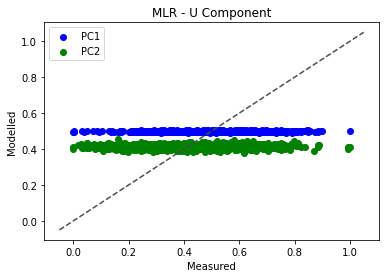

In [28]:
#plot MLR results

ax1 = plt.subplot(111)
ax1.scatter(y[0],ypred_MLR[:,0],c='b', label='PC1')
ax1.scatter(y[1],ypred_MLR[:,1],c='g', label='PC2')
l1 = np.min(ax1.get_xlim())
l2 = np.max(ax1.get_xlim())
ax1.plot([l1,l2], [l1,l2], ls="--", c=".3")
plt.xlabel('Measured')
plt.ylabel('Modelled')
plt.title('MLR - U Component') #/n R^2 = ' + str(R2_MLR))
plt.legend()

Now on V component

In [29]:
x = pd.DataFrame(V_RCM_norm)
y = pd.DataFrame(V_hrdps_norm)

In [30]:
#apply MLR on X and Y

lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(x,y)
ypred_MLR = lm_MLR.predict(x) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
#R2_MLR = lm_MLR.score(x,y) #R-squared value from MLR model

print('MLR results:')
print('a0 = ' + str(intercept_MLR))
print('a1 = ' + str(coef_MLR[0]))
# print('a2 = ' + str(coef_MLR[1]))
# print('a3 = ' + str(coef_MLR[2]))
# print('a4 = ' + str(coef_MLR[3]))
#print("R^2 =" + str(R2_MLR))

MLR results:
a0 = [0.4315991  0.44120097]
a1 = [ 0.0602196  -0.01551979]


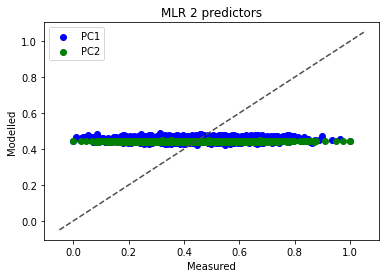

In [32]:
#plot MLR results

ax1 = plt.subplot(111)
ax1.scatter(y[0],ypred_MLR[:,0],c='b', label='PC1')
ax1.scatter(y[1],ypred_MLR[:,1],c='g', label='PC2')
l1 = np.min(ax1.get_xlim())
l2 = np.max(ax1.get_xlim())
ax1.plot([l1,l2], [l1,l2], ls="--", c=".3")
plt.xlabel('Measured')
plt.ylabel('Modelled')
plt.title('MLR 2 predictors')#\n R^2 = ' + str(R2_MLR))
plt.legend()

## Correlation Analysis
First with U component

In [33]:
x = U_RCM_norm[:,0] #CanRCM4 PCs as x
y = U_hrdps_norm[:,0] #HRDPS PCs as y

#calc r value
r = np.corrcoef(x,y)

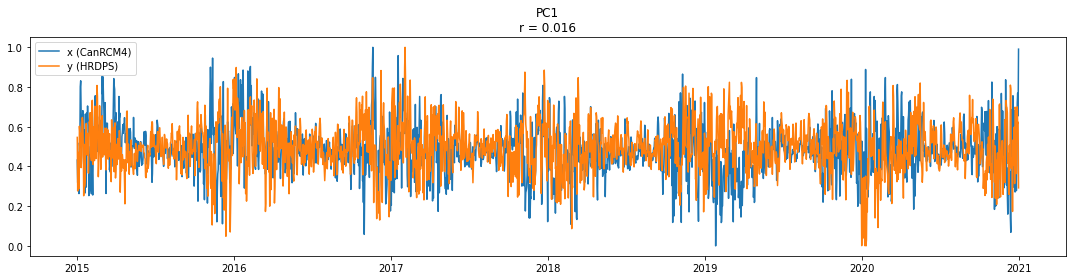

In [34]:
plt.figure(figsize=(15,4))

plt.plot(time2015,x)
plt.plot(time2015,y)
plt.legend(['x (CanRCM4)','y (HRDPS)'])
plt.title('PC1\nr = ' + str(r[0][1])[:5])


plt.tight_layout()

In [35]:
x = U_RCM_norm[:,1] #CanRCM4 PCs as x
y = U_hrdps_norm[:,1] #HRDPS PCs as y

#calc r value
r = np.corrcoef(x,y)

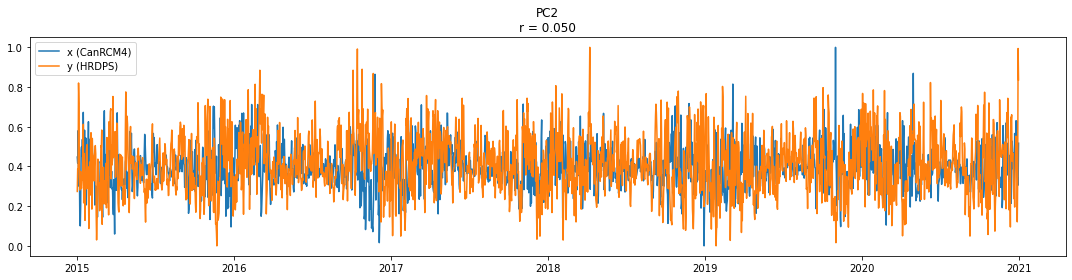

In [36]:
plt.figure(figsize=(15,4))

plt.plot(time2015,x)
plt.plot(time2015,y)
plt.legend(['x (CanRCM4)','y (HRDPS)'])
plt.title('PC2\nr = ' + str(r[0][1])[:5])


plt.tight_layout()

Next with V-component

In [43]:
x = U_RCM_norm[:,:2] #CanRCM4 PCs as x
y = U_hrdps_norm[:,:2] #HRDPS PCs as y

#calc r value
n_modes = 2 #modes to keep
r = [np.corrcoef(x[:,ii],y[:,ii])[0][1] for ii in range(n_modes)]

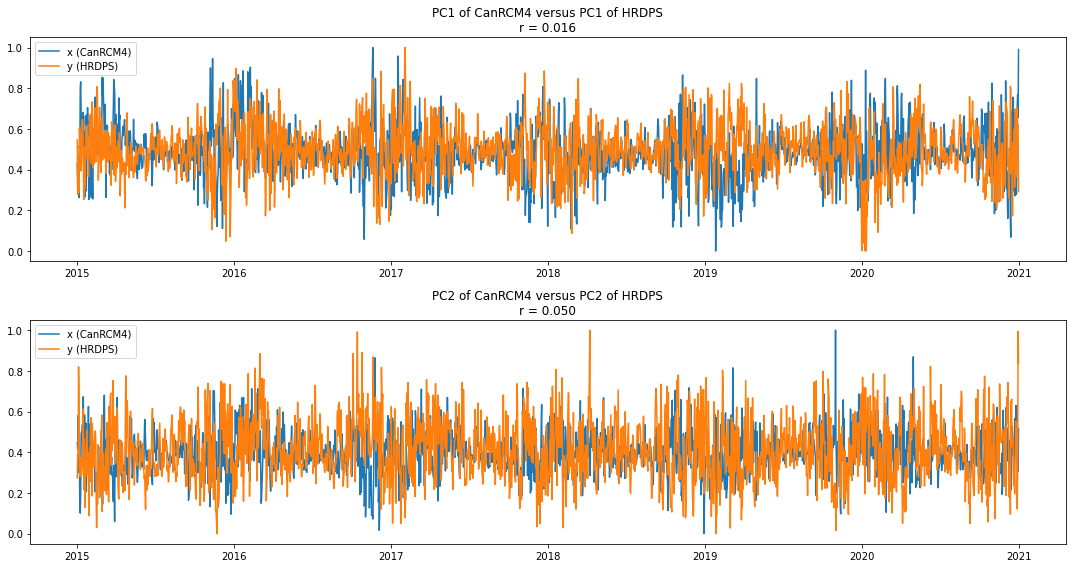

In [45]:
plt.figure(figsize=(15,8))

plt.subplot(2,1,1)
plt.plot(time2015, x[:,0])
plt.plot(time2015,y[:,0])
plt.legend(['x (CanRCM4)','y (HRDPS)'])
plt.title('PC1 of CanRCM4 versus PC1 of HRDPS\nr = ' + str(r[0])[:5])

plt.subplot(2,1,2)
plt.plot(time2015,x[:,1])
plt.plot(time2015,y[:,1])
plt.legend(['x (CanRCM4)','y (HRDPS)'])
plt.title('PC2 of CanRCM4 versus PC2 of HRDPS\nr = ' + str(r[1])[:5])

plt.tight_layout()

## Variance Analysis
looking at how the total variance in the winter months varies from year to year and between datasets<br>

U-component first

In [46]:
#Select  data first
x = U_RCM_norm[:,:2] #CanRCM4 PCAs as x
y = U_hrdps_norm[:,:2] #HRDPS PCAs as y

In [47]:
#split datasets into different arrays for winters 2015/2016, 2016/2017, 2017/2018, 2018/2019, 2019/2020
#set 'winter' in Canada as October 1 - March 31

octo = 274 -1 #october 1 is the 274th day of the year (so ind 273)
mar = 365 + 90 - 1 #march 31 is the 90th day of the following year

WinterRCM1 = np.empty([5,(mar-octo)]) #one array for each PC of dataset (each row for each year)
WinterRCM2 = np.empty([5,(mar-octo)])
WinterHRDPS1 = np.empty([5,(mar-octo)])
WinterHRDPS2 = np.empty([5,(mar-octo)])

for i in range(5):
    for j in range(mar-octo):
        WinterRCM1[i,j] = x[octo+(i*365)+j,0]
        WinterRCM2[i,j] = x[octo+(i*365)+j,1]
        WinterHRDPS1[i,j] = y[octo+(i*365)+j,0]
        WinterHRDPS2[i,j] = y[octo+(i*365)+j,1]

In [48]:
#get variance of each year
def var(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
    
varRCM1 = list(range(5))
varRCM2 = list(range(5))
varHRDPS1 = list(range(5))
varHRDPS2 = list(range(5))

for i in range(5):
    varRCM1[i]=var(WinterRCM1[i,:])
    varRCM2[i]=var(WinterRCM2[i,:])
    varHRDPS1[i]=var(WinterHRDPS1[i,:])
    varHRDPS2[i]=var(WinterHRDPS2[i,:])

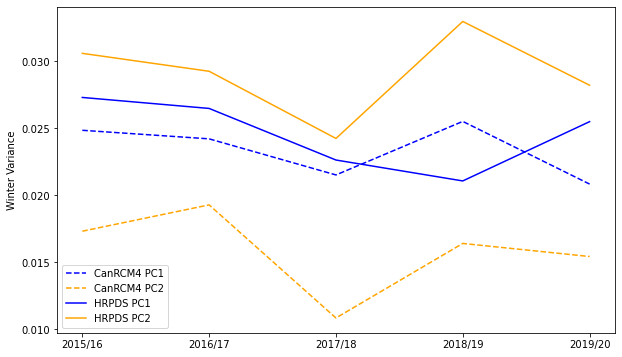

In [49]:
years = ['2015/16','2016/17','2017/18','2018/19','2019/20',]

plt.figure(figsize=(10,6))

plt.plot(years, varRCM1, label='CanRCM4 PC1',c='b',ls='--')
plt.plot(years, varRCM2, label='CanRCM4 PC2',c='orange',ls='--')
plt.plot(years, varHRDPS1, label='HRPDS PC1',c='b')
plt.plot(years, varHRDPS2, label='HRPDS PC2',c='orange')
plt.ylabel('Winter Variance')
#plt.xticks([0,1,2],['PC1','PC2','PC3'])
plt.legend()

Now with V component

In [50]:
#Select  data first
x = V_RCM_norm[:,:2] #CanRCM4 PCAs as x
y = V_hrdps_norm[:,:2] #HRDPS PCAs as y

In [51]:
#split datasets into different arrays for winters 2015/2016, 2016/2017, 2017/2018, 2018/2019, 2019/2020
#set 'winter' in Canada as October 1 - March 31

octo = 274 -1 #october 1 is the 274th day of the year (so ind 273)
mar = 365 + 90 - 1 #march 31 is the 90th day of the following year

V_WinterRCM1 = np.empty([5,(mar-octo)]) #one array for each PC of dataset (each row for each year)
V_WinterRCM2 = np.empty([5,(mar-octo)])
V_WinterHRDPS1 = np.empty([5,(mar-octo)])
V_WinterHRDPS2 = np.empty([5,(mar-octo)])

for i in range(5):
    for j in range(mar-octo):
        V_WinterRCM1[i,j] = x[octo+(i*365)+j,0]
        V_WinterRCM2[i,j] = x[octo+(i*365)+j,1]
        V_WinterHRDPS1[i,j] = y[octo+(i*365)+j,0]
        V_WinterHRDPS2[i,j] = y[octo+(i*365)+j,1]

In [52]:
#get variance of each year
def var(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
    
varRCM1 = list(range(5))
varRCM2 = list(range(5))
varHRDPS1 = list(range(5))
varHRDPS2 = list(range(5))

for i in range(5):
    varRCM1[i]=var(V_WinterRCM1[i,:])
    varRCM2[i]=var(V_WinterRCM2[i,:])
    varHRDPS1[i]=var(V_WinterHRDPS1[i,:])
    varHRDPS2[i]=var(V_WinterHRDPS2[i,:])

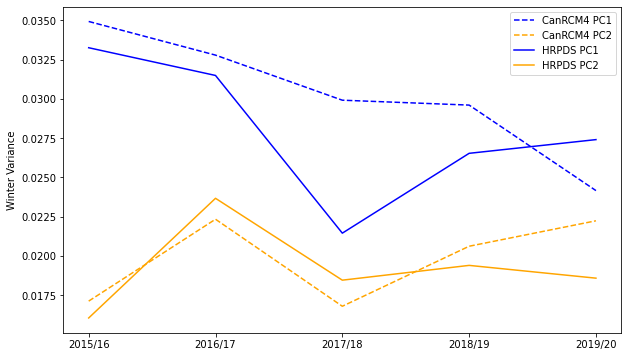

In [53]:
years = ['2015/16','2016/17','2017/18','2018/19','2019/20',]

plt.figure(figsize=(10,6))

plt.plot(years, varRCM1, label='CanRCM4 PC1',c='b',ls='--')
plt.plot(years, varRCM2, label='CanRCM4 PC2',c='orange',ls='--')
plt.plot(years, varHRDPS1, label='HRPDS PC1',c='b')
plt.plot(years, varHRDPS2, label='HRPDS PC2',c='orange')
plt.ylabel('Winter Variance')
#plt.xticks([0,1,2],['PC1','PC2','PC3'])
plt.legend()

## Histograms
Idea #1: histogram of time spent in magnitude bins 0.1 points in width between 0 and 1<br>

U-component first:

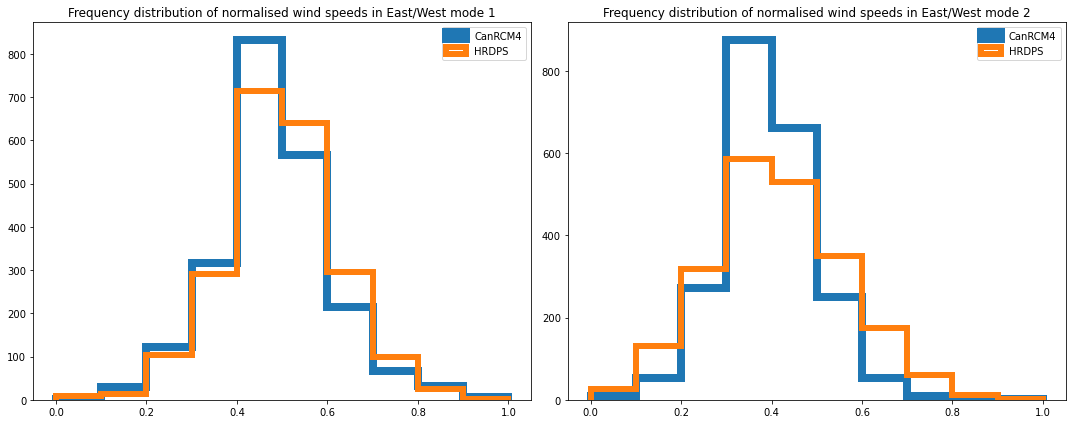

In [71]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.hist(U_RCM_norm[:,0],bins=10,histtype='step',linewidth=8,label='CanRCM4')
plt.hist(U_hrdps_norm[:,0],bins=10,histtype='step',linewidth=6,label='HRDPS')
plt.legend()
plt.title('Frequency distribution of normalised wind speeds in East/West mode 1')

plt.subplot(1,2,2)
plt.hist(U_RCM_norm[:,1],bins=10,histtype='step',linewidth=8,label='CanRCM4')
plt.hist(U_hrdps_norm[:,1],bins=10,histtype='step',linewidth=6,label='HRDPS')
plt.legend()
plt.title('Frequency distribution of normalised wind speeds in East/West mode 2')

plt.tight_layout()

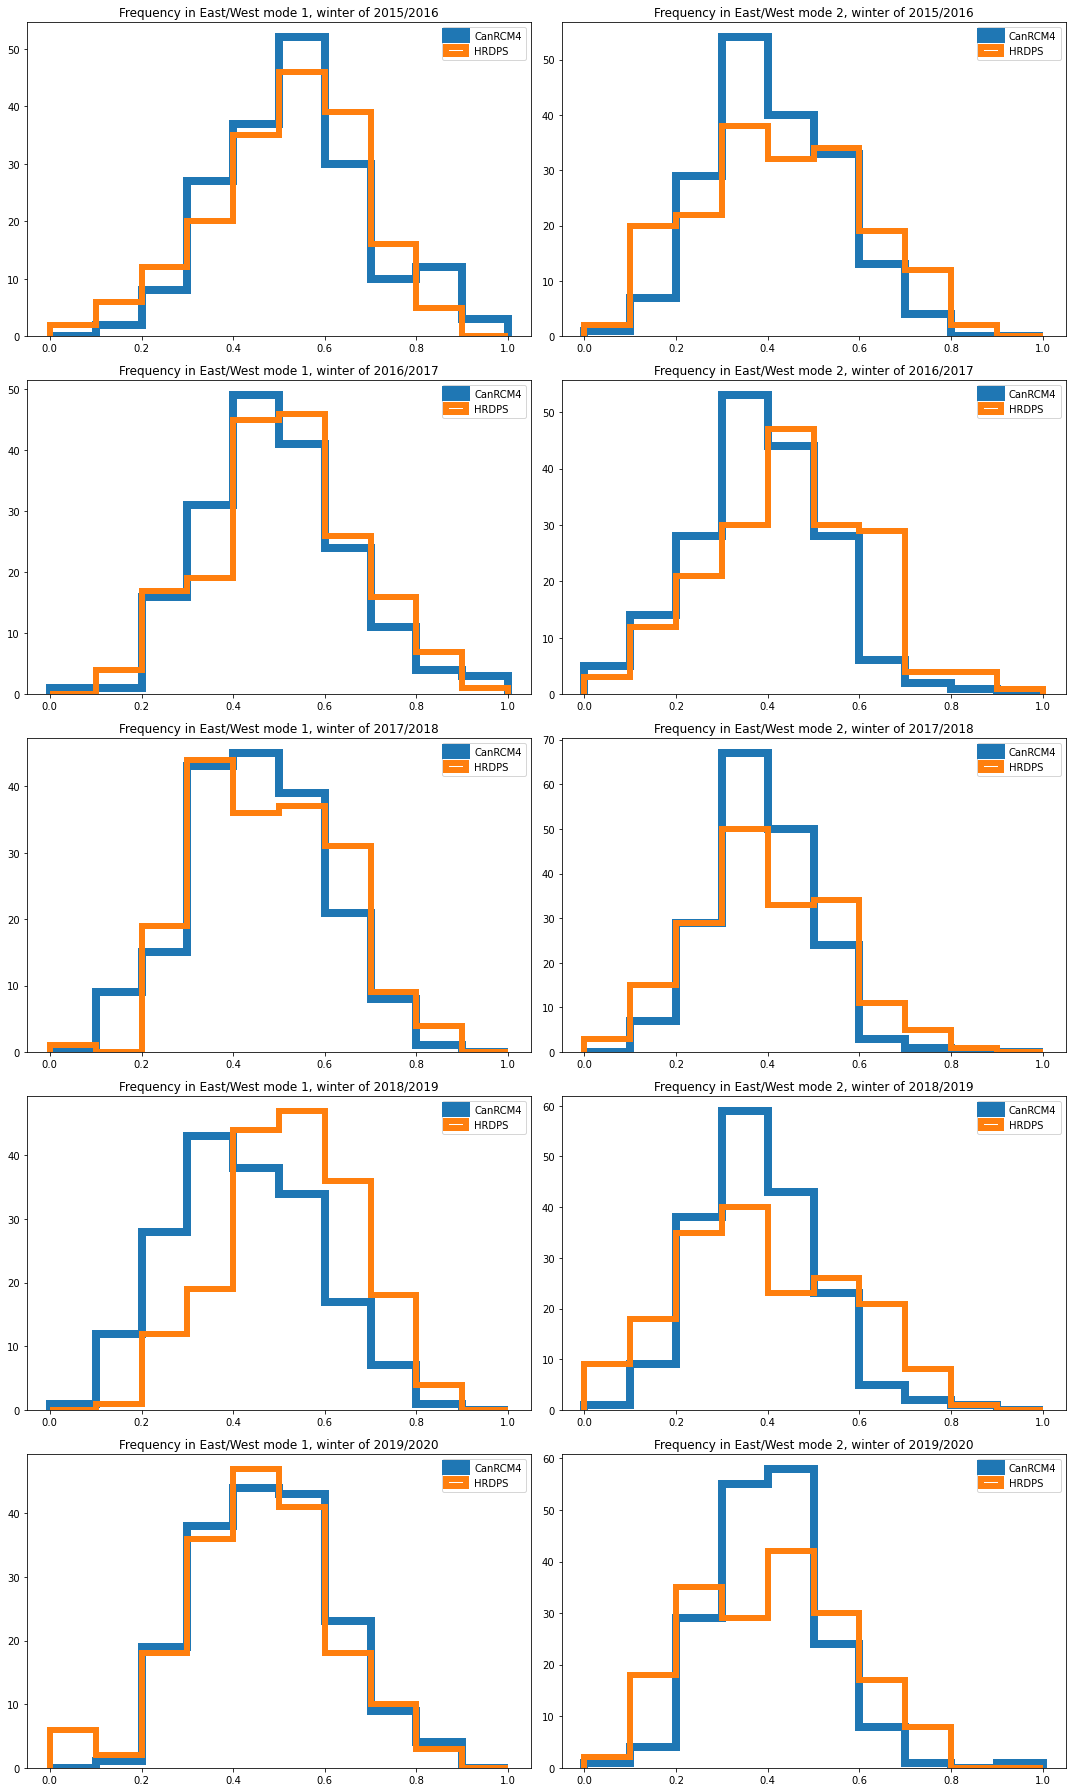

In [87]:
#look at it by winter
n = 5 #number of winters
b = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.hist(WinterRCM1[kk,:],bins=b,histtype='step',linewidth=8,label='CanRCM4')
    plt.hist(WinterHRDPS1[kk,:],bins=b,histtype='step',linewidth=6,label='HRDPS')
    plt.legend()
    plt.title('Frequency in East/West mode 1, winter of 201'+str(5+kk)+'/20'+str(16+kk))
    
    plt.subplot(n,2,(kk+1)*2)
    plt.hist(WinterRCM2[kk,:],bins=b,histtype='step',linewidth=8,label='CanRCM4')
    plt.hist(WinterHRDPS2[kk,:],bins=b,histtype='step',linewidth=6,label='HRDPS')
    plt.legend()
    plt.title('Frequency in East/West mode 2, winter of 201'+str(5+kk)+'/20'+str(16+kk))
    
    plt.tight_layout()

V-component

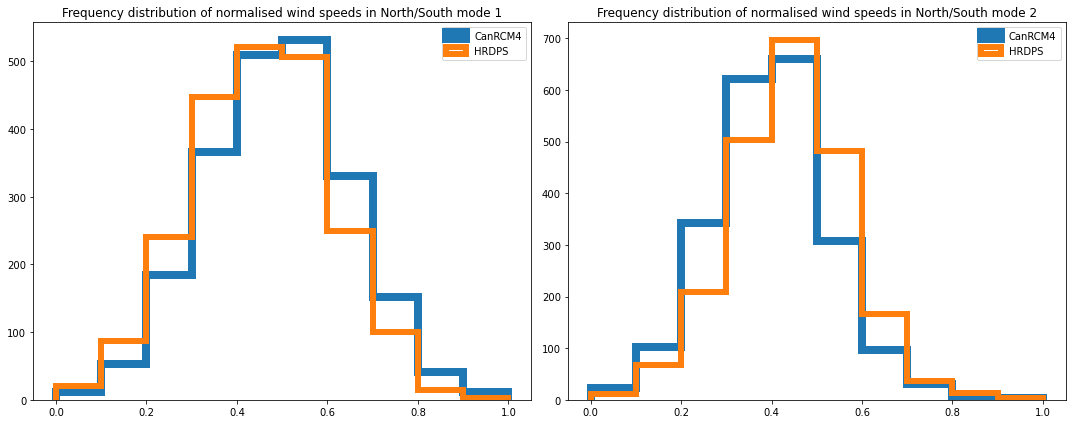

In [88]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.hist(V_RCM_norm[:,0],bins=10,histtype='step',linewidth=8,label='CanRCM4')
plt.hist(V_hrdps_norm[:,0],bins=10,histtype='step',linewidth=6,label='HRDPS')
plt.legend()
plt.title('Frequency distribution of normalised wind speeds in North/South mode 1')

plt.subplot(1,2,2)
plt.hist(V_RCM_norm[:,1],bins=10,histtype='step',linewidth=8,label='CanRCM4')
plt.hist(V_hrdps_norm[:,1],bins=10,histtype='step',linewidth=6,label='HRDPS')
plt.legend()
plt.title('Frequency distribution of normalised wind speeds in North/South mode 2')

plt.tight_layout()

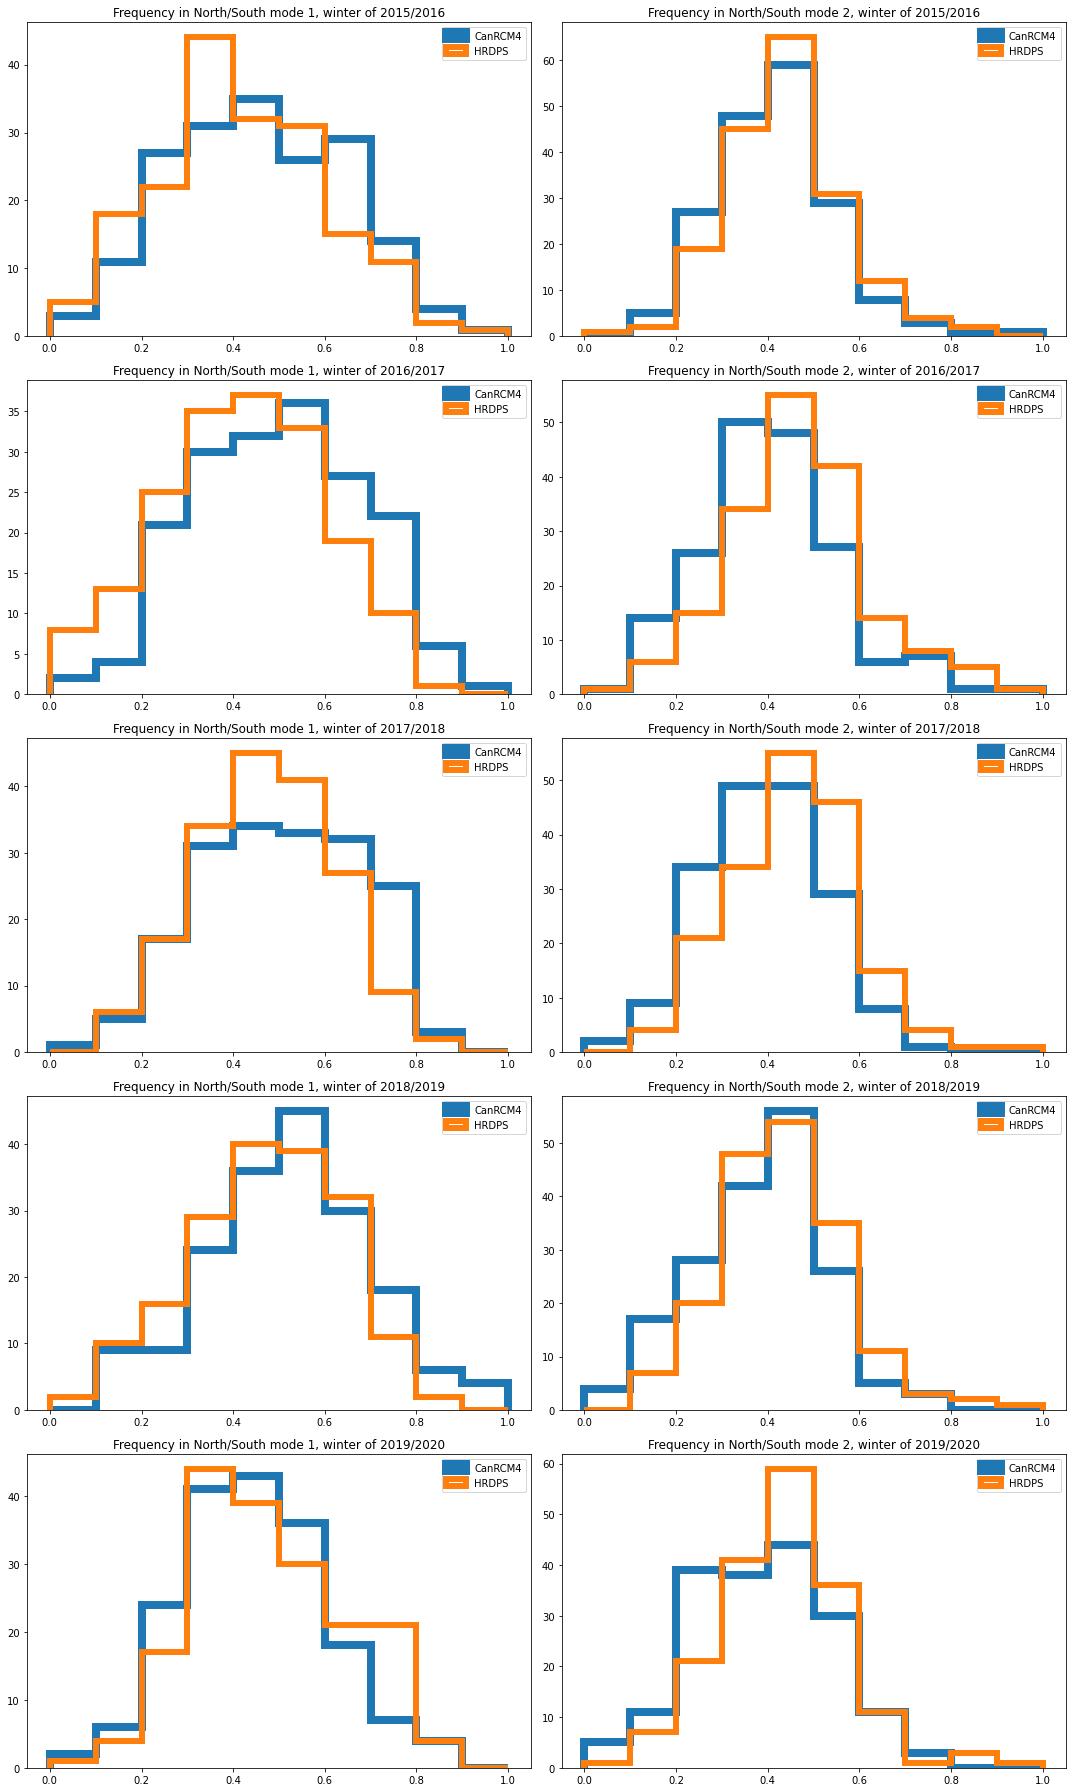

In [89]:
#look at it by winter
n = 5 #number of winters
b = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.hist(V_WinterRCM1[kk,:],bins=b,histtype='step',linewidth=8,label='CanRCM4')
    plt.hist(V_WinterHRDPS1[kk,:],bins=b,histtype='step',linewidth=6,label='HRDPS')
    plt.legend()
    plt.title('Frequency in North/South mode 1, winter of 201'+str(5+kk)+'/20'+str(16+kk))
    
    plt.subplot(n,2,(kk+1)*2)
    plt.hist(V_WinterRCM2[kk,:],bins=b,histtype='step',linewidth=8,label='CanRCM4')
    plt.hist(V_WinterHRDPS2[kk,:],bins=b,histtype='step',linewidth=6,label='HRDPS')
    plt.legend()
    plt.title('Frequency in North/South mode 2, winter of 201'+str(5+kk)+'/20'+str(16+kk))
    
    plt.tight_layout()

## Count switches in wind direction each winter

In [104]:
U_switch_RCM1 = list(range(5))
U_switch_RCM2 = list(range(5))
V_switch_RCM1 = list(range(5))
V_switch_RCM2 = list(range(5))
U_switch_HRDPS1 = list(range(5))
U_switch_HRDPS2 = list(range(5))
V_switch_HRDPS1 = list(range(5))
V_switch_HRDPS2 = list(range(5))

for i in range(5): #again, 5 for 5 winters
    for j in range(mar-octo-1):
        if (WinterRCM1[i,j]>0.5 and WinterRCM1[i,j+1]<0.5) or (WinterRCM1[i,j]<0.5 and WinterRCM1[i,j+1]>0.5):
            U_switch_RCM1[i]+=1
        if (WinterRCM2[i,j]>0.5 and WinterRCM2[i,j+1]<0.5) or (WinterRCM2[i,j]<0.5 and WinterRCM2[i,j+1]>0.5):
            U_switch_RCM2[i]+=1
        if (V_WinterRCM1[i,j]>0.5 and V_WinterRCM1[i,j+1]<0.5) or (V_WinterRCM1[i,j]<0.5 and V_WinterRCM1[i,j+1]>0.5):
            V_switch_RCM1[i]+=1
        if (V_WinterRCM2[i,j]>0.5 and V_WinterRCM2[i,j+1]<0.5) or (V_WinterRCM2[i,j]<0.5 and V_WinterRCM2[i,j+1]>0.5):
            V_switch_RCM2[i]+=1
        if (WinterHRDPS1[i,j]>0.5 and WinterHRDPS1[i,j+1]<0.5) or (WinterHRDPS1[i,j]<0.5 and WinterHRDPS1[i,j+1]>0.5):
            U_switch_HRDPS1[i]+=1
        if (WinterHRDPS2[i,j]>0.5 and WinterHRDPS2[i,j+1]<0.5) or (WinterHRDPS2[i,j]<0.5 and WinterHRDPS2[i,j+1]>0.5):
            U_switch_HRDPS2[i]+=1
        if (V_WinterHRDPS1[i,j]>0.5 and V_WinterHRDPS1[i,j+1]<0.5) or (V_WinterHRDPS1[i,j]<0.5 and V_WinterHRDPS1[i,j+1]>0.5):
            V_switch_HRDPS1[i]+=1
        if (V_WinterHRDPS2[i,j]>0.5 and V_WinterHRDPS2[i,j+1]<0.5) or (V_WinterHRDPS2[i,j]<0.5 and V_WinterHRDPS2[i,j+1]>0.5):
            V_switch_HRDPS2[i]+=1

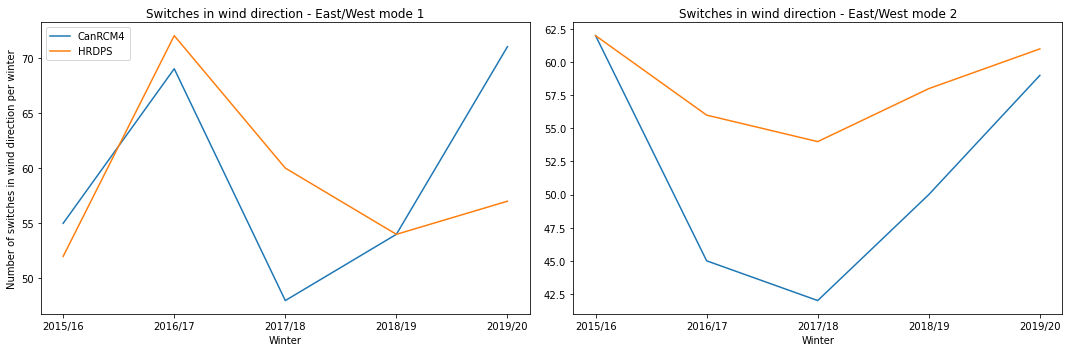

In [105]:
plt.figure(figsize=(15,5))
x_axis=['2015/16','2016/17','2017/18','2018/19','2019/20']

plt.subplot(1,2,1)
plt.plot(x_axis,U_switch_RCM1,label='CanRCM4')
plt.plot(x_axis,U_switch_HRDPS1,label='HRDPS')
plt.ylabel('Number of switches in wind direction per winter')
plt.xlabel('Winter')
plt.legend()
plt.title('Switches in wind direction - East/West mode 1')

plt.subplot(1,2,2)
plt.plot(x_axis,U_switch_RCM2)#label='CanRCM4')
plt.plot(x_axis,U_switch_HRDPS2)#label='HRDPS')
plt.xlabel('Winter')
# plt.legend()
plt.title('Switches in wind direction - East/West mode 2')

plt.tight_layout()

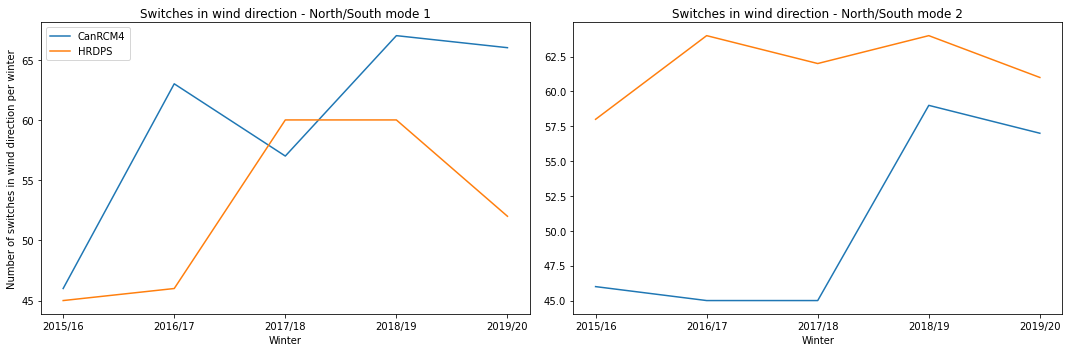

In [106]:
plt.figure(figsize=(15,5))
x_axis=['2015/16','2016/17','2017/18','2018/19','2019/20']

plt.subplot(1,2,1)
plt.plot(x_axis,V_switch_RCM1,label='CanRCM4')
plt.plot(x_axis,V_switch_HRDPS1,label='HRDPS')
plt.ylabel('Number of switches in wind direction per winter')
plt.xlabel('Winter')
plt.legend()
plt.title('Switches in wind direction - North/South mode 1')

plt.subplot(1,2,2)
plt.plot(x_axis,V_switch_RCM2)#label='CanRCM4')
plt.plot(x_axis,V_switch_HRDPS2)#label='HRDPS')
plt.xlabel('Winter')
# plt.legend()
plt.title('Switches in wind direction - North/South mode 2')

plt.tight_layout()

## Grid-search optimization
First with U-component

In [24]:
# #define RMSE as a function
# def rmse(target,prediction):
#     return(np.sqrt(((target - prediction)**2).sum()/len(target)))

In [25]:
# #set training and validation data
# #recall that we chose 3 PCs for RCM model u-component and 3 PCs for HRDPS u-component
# nPCs_RCM = 3
# nPCs_hrdps = 2

# x = U_RCM_PCs[:,:nPCs_RCM] #CanRCM4 PCAs as input
# y = U_hrdps_PCs[:,:nPCs_hrdps] #HRDPS PCAs as output

# Ntrain = int(len(y)*0.8) #take 80% of the total data to be for training
# x_train = x[:Ntrain]
# y_train = y[:Ntrain]

# x_test = x[Ntrain:]
# U_y_test = y[Ntrain:]

In [19]:
# #This chunk of code is relatively flexible and can be used to loop through a range of parameters
# #We'll use this code several different times in the notebook
# #Play around and see what kinds of models you can make

# #First: MLP using 1 hidden layer with 10 neurons
# #Second: MLP using 1 hidden layer with 1-10 neurons
# #Third: play around with it!

# ##### Play around with these parameters
# num_models = 20 #number of models to build for the ensemble
# min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
# max_nhn = 30 #maximum number of hidden neurons to loop through, times steps for training equals 30 at this moment
# max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
# batch_size = 20
# solver = 'sgd' #use stochastic gradient descent as an optimization method (weight updating algorithm)
# activation = 'relu'
# learning_rate_init = 0.001
# max_iter = 2000 #max number of epochs to run for any model
# early_stopping = True #True = stop early if validation error begins to rise
# validation_fraction = 0.25 #fraction of training data to use as validation
# #####

# y_out_all_nhn = []
# # q5y_all = []
# # q5y_ensemble = []
# bestmodels = []
# U_y_out_ensemble = []
# RMSE_ensemble = [] #RMSE for each model in the ensemble
# RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
# nhn_best = []
# nhl_best = []

# for model_num in range(num_models): #for each model in the ensemble
    
#     print('Model Number: ' + str(model_num))
    
#     models = []
#     RMSE = []
#     y_out_all_nhn = []
#     nhn = []
#     nhl = []
    
#     for num_hidden_layers in range(1,max_hidden_layers+1):
    
#         #print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
#         for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

#             #print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
#             hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
#             model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
#                                  verbose=False,
#                                  max_iter=max_iter, 
#                                  early_stopping = early_stopping,
#                                  validation_fraction = validation_fraction,
#                                  batch_size = batch_size,
#                                  solver = solver,
#                                  activation = activation,
#                                  learning_rate_init = learning_rate_init)

#             model.fit(x_train,y_train) #train the model
#             models.append(model) #add the models to list to be accessed later

#             y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
#             y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE
            
#             #now export the models from each run

#             RMSE.append(rmse(U_y_test,y_out_this_nhn)) #RMSE of this model
            
#             nhn.append(num_hidden_neurons)
#             nhl.append(num_hidden_layers)
        
#     indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
#     RMSE_ensemble.append(np.min(RMSE))
#     nhn_best.append(nhn[indBest])
#     nhl_best.append(nhl[indBest])
#     #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
#     U_y_out_ensemble.append(y_out_all_nhn[indBest])
#     bestmodels.append(models[indBest]) #only save the models that worked the best
    
#     print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
# y_out_ensemble_mean = np.mean(U_y_out_ensemble,axis=0)
# RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

In [27]:
# #plot RMSE for each run
# plt.figure(figsize=(8,4))

# plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*',label='Ensemble RMSE')
# plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
# plt.xlabel('Model #')
# plt.xticks(np.arange(0, 20, step=1))
# plt.ylabel('RMSE')
# plt.title('Error')
# plt.legend(fontsize = 12, loc = 'best')

# plt.savefig('RMSE.png')

NameError: name 'RMSE_ensemble_mean' is not defined

<Figure size 576x288 with 0 Axes>

In [35]:
# # therefore based on this grid-search optimization pick model with lowest RMSE for the reconstruction
# U_model = bestmodels[RMSE_ensemble.index(min(RMSE_ensemble))]
# print(U_model)

MLPRegressor(batch_size=20, early_stopping=True, hidden_layer_sizes=(27, 2),
             max_iter=2000, solver='sgd', validation_fraction=0.25)


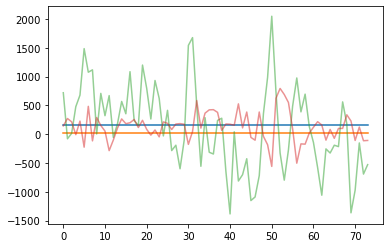

In [36]:
# plt.plot(U_y_out_ensemble[RMSE_ensemble.index(min(RMSE_ensemble))])
# plt.plot(U_y_test,alpha = 0.5)

Next with V component

In [37]:
# #set training and validation data
# nPCs_RCM = 3
# nPCs_hrdps = 2


# x = V_RCM_PCs[:,:nPCs_RCM] #CanRCM4 PCAs as input
# y = V_hrdps_PCs[:,:nPCs_hrdps] #HRDPS PCAs as output

# Ntrain = int(len(y)*0.8) #take 80% of the total data to be for training
# x_train = x[:Ntrain]
# y_train = y[:Ntrain]

# x_test = x[Ntrain:]
# V_y_test = y[Ntrain:]

In [38]:
# #This chunk of code is relatively flexible and can be used to loop through a range of parameters
# #We'll use this code several different times in the notebook
# #Play around and see what kinds of models you can make

# #First: MLP using 1 hidden layer with 10 neurons
# #Second: MLP using 1 hidden layer with 1-10 neurons
# #Third: play around with it!

# ##### Play around with these parameters
# num_models = 20 #number of models to build for the ensemble
# min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
# max_nhn = 30 #maximum number of hidden neurons to loop through, times steps for training equals 30 at this moment
# max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
# batch_size = 20
# solver = 'sgd' #use stochastic gradient descent as an optimization method (weight updating algorithm)
# activation = 'relu'
# learning_rate_init = 0.001
# max_iter = 2000 #max number of epochs to run for any model
# early_stopping = True #True = stop early if validation error begins to rise
# validation_fraction = 0.25 #fraction of training data to use as validation
# #####

# y_out_all_nhn = []
# # q5y_all = []
# # q5y_ensemble = []
# bestmodels = []
# V_y_out_ensemble = []
# RMSE_ensemble = [] #RMSE for each model in the ensemble
# RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
# nhn_best = []
# nhl_best = []

# for model_num in range(num_models): #for each model in the ensemble
    
#     print('Model Number: ' + str(model_num))
    
#     models = []
#     RMSE = []
#     y_out_all_nhn = []
#     nhn = []
#     nhl = []
    
#     for num_hidden_layers in range(1,max_hidden_layers+1):
    
#         #print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
#         for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

#             #print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
#             hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
#             model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
#                                  verbose=False,
#                                  max_iter=max_iter, 
#                                  early_stopping = early_stopping,
#                                  validation_fraction = validation_fraction,
#                                  batch_size = batch_size,
#                                  solver = solver,
#                                  activation = activation,
#                                  learning_rate_init = learning_rate_init)

#             model.fit(x_train,y_train) #train the model
#             models.append(model) #add the models to list to be accessed later

#             y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
#             y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE
            
#             #now export the models from each run

#             RMSE.append(rmse(V_y_test,y_out_this_nhn)) #RMSE of this model
            
#             nhn.append(num_hidden_neurons)
#             nhl.append(num_hidden_layers)
        
#     indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
#     RMSE_ensemble.append(np.min(RMSE))
#     nhn_best.append(nhn[indBest])
#     nhl_best.append(nhl[indBest])
#     #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
#     V_y_out_ensemble.append(y_out_all_nhn[indBest])
#     bestmodels.append(models[indBest]) #only save the models that worked the best
    
#     print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
# y_out_ensemble_mean = np.mean(V_y_out_ensemble,axis=0)
# RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

Model Number: 0
	 BEST: 1 hidden layers, 24 hidden neurons
Model Number: 1


/home/rbeutel/anaconda3/envs/eosc510/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


	 BEST: 2 hidden layers, 25 hidden neurons
Model Number: 2
	 BEST: 2 hidden layers, 13 hidden neurons
Model Number: 3
	 BEST: 2 hidden layers, 15 hidden neurons
Model Number: 4
	 BEST: 2 hidden layers, 11 hidden neurons
Model Number: 5
	 BEST: 2 hidden layers, 1 hidden neurons
Model Number: 6
	 BEST: 1 hidden layers, 8 hidden neurons
Model Number: 7
	 BEST: 2 hidden layers, 10 hidden neurons
Model Number: 8
	 BEST: 2 hidden layers, 9 hidden neurons
Model Number: 9
	 BEST: 2 hidden layers, 26 hidden neurons
Model Number: 10
	 BEST: 2 hidden layers, 3 hidden neurons
Model Number: 11
	 BEST: 2 hidden layers, 17 hidden neurons
Model Number: 12
	 BEST: 2 hidden layers, 17 hidden neurons
Model Number: 13
	 BEST: 2 hidden layers, 10 hidden neurons
Model Number: 14
	 BEST: 2 hidden layers, 7 hidden neurons
Model Number: 15
	 BEST: 2 hidden layers, 8 hidden neurons
Model Number: 16
	 BEST: 2 hidden layers, 11 hidden neurons
Model Number: 17
	 BEST: 2 hidden layers, 1 hidden neurons
Model Number

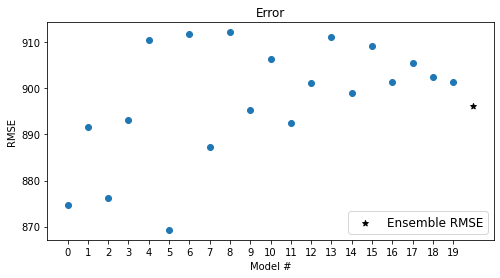

In [39]:
# #plot RMSE for each run
# plt.figure(figsize=(8,4))

# plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*',label='Ensemble RMSE')
# plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
# plt.xlabel('Model #')
# plt.xticks(np.arange(0, 20, step=1))
# plt.ylabel('RMSE')
# plt.title('Error')
# plt.legend(fontsize = 12, loc = 'best')

# plt.savefig('RMSE2.png')

In [40]:
# # therefore based on this grid-search optimization pick model with lowest RMSE for the reconstruction
# V_model = bestmodels[RMSE_ensemble.index(min(RMSE_ensemble))]
# print(V_model)

MLPRegressor(batch_size=20, early_stopping=True, hidden_layer_sizes=(1, 2),
             max_iter=2000, solver='sgd', validation_fraction=0.25)


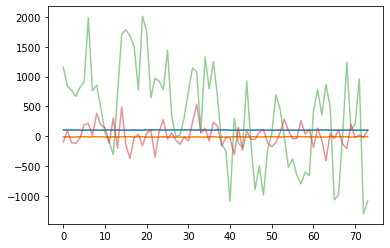

In [41]:
# plt.plot(V_y_out_ensemble[RMSE_ensemble.index(min(RMSE_ensemble))])
# plt.plot(V_y_test,alpha = 0.5)

## Future prediction and reconstruction

In [100]:
# #lets load in one more month of CanRCM4 model and make a 'prediction' on what the winds would look like in that month
# U_world= xr.open_dataset("uas_NAM-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20160101-20201231.nc")
# V_world = xr.open_dataset("vas_NAM-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20160101-20201231.nc")

# #want days between July 1 2018 and July 31 2018
# U_world = U_world.sel(time=slice('2019-01-01 12:00:00', '2019-12-31 12:00:00')) 
# V_world = V_world.sel(time=slice('2019-01-01 12:00:00', '2019-12-31 12:00:00'))

# #now extract the data you want from the CanRCM4 xarray and trim them according to lat and lon of the HRDPS data
# #don't need to retrim or re-extract the lat and lon coordinates as they will be the same as before
# #convert the wind data to 2D and use the idices found earlier to trim it
# U2d = np.empty((np.shape(U_world.uas.values)[1]*np.shape(U_world.uas.values)[2],np.shape(U_world.uas.values)[0]))
# for i in range(np.shape(U_world.uas.values)[0]):
#     U2d[:,i] = np.reshape(U_world.uas.values[i],(np.shape(U_world.uas.values)[1]*np.shape(U_world.uas.values)[2],))

# V2d = np.empty((np.shape(V_world.vas.values)[1]*np.shape(V_world.vas.values)[2],np.shape(V_world.vas.values)[0]))
# for i in range(np.shape(V_world.vas.values)[0]):
#     V2d[:,i] = np.reshape(V_world.vas.values[i],(np.shape(V_world.vas.values)[1]*np.shape(V_world.vas.values)[2],))

# Ufuture = np.empty((len(index),len(U_world.time)))
# Vfuture = np.empty((len(index),len(V_world.time)))

# for i in range(len(U_world.time)):
#     for j in range(len(index)):
#         Ufuture[j,i] = U2d[index[j],i]
#         Vfuture[j,i] = V2d[index[j],i]

In [101]:
# #do PCA and take the same amount of modes as before (only actually need the PCs not the eigenvecs)
# data = Ufuture.T

# n_modes = np.min(np.shape(data))
# pca = PCA(n_components = n_modes)
# U_PCs = pca.fit_transform(data)

# data = Vfuture.T

# n_modes = np.min(np.shape(data))
# pca = PCA(n_components = n_modes)
# V_PCs = pca.fit_transform(data)

In [103]:
# #put input data in correct form
# U = U_PCs[:,:3] 
# V = V_PCs[:,:3] 

In [104]:
# #predict
# U_PCoutput = U_model.predict(U)
# V_PCoutput = V_model.predict(V)

In [122]:
#reconstruct this bitch

numObs = np.shape(U_hrdps_eigvecs)[0]-1
data_U_rec = np.empty([numObs,51338])
for kk in range(numObs): #for each time step
    this_U_rec = np.zeros([1,51338])
    for mode in range(2): #range is number of modes we kept (3 for U and 2 for V)
        this_U_rec += U_hrdps_eigvecs[mode,:]*U_PCoutput[kk,mode]    
    data_U_rec[kk,:] = this_U_rec
    
numObs = np.shape(V_hrdps_eigvecs)[0]-1
data_V_rec = np.empty([numObs,51338])
for kk in range(numObs): #for each time step
    this_V_rec = np.zeros([1,51338])
    for mode in range(2): #range is number of modes we kept (3 for U and 2 for V)
        this_V_rec += U_hrdps_eigvecs[mode,:]*V_PCoutput[kk,mode]    
    data_V_rec[kk,:] = this_V_rec

In [131]:
# #visualize reconstruction
# plt.figure(figsize=(15,5))

    
# plt.subplot(1,2,1)
# plt.scatter(hrdps_lon, hrdps_lat,
#             c = data_U_rec[0,:],
#             cmap = 'RdBu_r',
#             s = 10,
#             marker = 's')
# plt.title('Example of the Predicted Wind Speed, East-West Component')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.colorbar()

# plt.subplot(1,2,2)
# plt.scatter(hrdps_lon, hrdps_lat,
#             c = data_V_rec[0,:],
#             cmap = 'RdBu_r',
#             s = 10,
#             marker = 's')
# plt.title('Example of the Predicted Wind Speed, North-South Component')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.colorbar()

# plt.savefig('Reconstruction.png')

# plt.tight_layout()

In [132]:
# #load in actual HRDPS data from that day to compare
# compare= xr.open_dataset(path/path2/"ops_y2016m06d01.nc")

# #get into daily
# compare = compare.resample(time_counter='D').mean(dim='time_counter')


In [133]:
# #plot u component
# compare.u_wind[0,:,:].plot()
# #plt.savefig('HRDPSdata.png')

In [134]:
# #plot v component
# compare.v_wind[0,:,:].plot()